In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# !pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00


In [6]:
# pip install Sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00


In [7]:
# pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


In [8]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
import transformers
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
%cd /content/drive/My Drive/Thesis

/content/drive/My Drive/Thesis


In [10]:
# Load the dataset
df = pd.read_csv('train_data.csv')
df

,id,title,text,label
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...,...
72027,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
72028,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
72029,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
72030,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


There are 4 columns in the dataset, of which only the title and the label is used for this study. '0' in 'label' denotes 'Fake News' and '1' denotes 'True news'. Limiting the scope to 'title'(headlines) only, because of the time and computational constraints primarily.

In [11]:
# Dropping the columns 'id' and 'text'
df.drop(columns=['id','text'],inplace = True)

In [12]:
df = df.dropna()
df.isnull().sum()

title    0
label    0
dtype: int64

Creating a function for preprocessing the text. This function includes code for converting the text to lowercase, removing any numbers and punctuations and replacing them with a single space, converting the text to tokens, removing all the stopwords and joining the tokens back into a string. 
This snippet is bound as a function so that further studies can include the 'text' column also and the same function can be reused.

In [13]:
def preprocess(text):
  if isinstance(text, str):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r'[^\w\s]|[\d]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Join the tokens back into a string
    text = ' '.join(tokens)
    return text

In [14]:
# Applying the preprocessing to the 'title' column using apply() method
df['title'] = df['title'].apply(preprocess)

<ipython-input-14-add41be75acf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].apply(preprocess)


In [15]:
# Splitting the dataset into dependent and target data
X = df['title'] 
y = df['label']

In [16]:
# Splitting the dataset into train and test datasets (80:20 split). 
#'stratify' parameter will ensure that the same proportion of data is maintained in the split datasets as in the original one.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# Function to convert the tokenized text into a TF-IDF (Term Frequency - Inverse Document Frequency) matrix form
def tfidf_vectorizer(X_train, X_test):
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec

In [18]:
# Applying the tfidf vectorizer to the train and test X data splits
X_train_tfidf, X_test_tfidf = tfidf_vectorizer(X_train, X_test)

In [19]:
X_train_tfidf

<57179x33560 sparse matrix of type '<class 'numpy.float64'>'
	with 505883 stored elements in Compressed Sparse Row format>

In [20]:
# Text preprocessing
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(X_train)

In [21]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [22]:
# Padding
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [23]:
# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

##BERT

In [29]:
# Load the BERT tokenizer pretrained on 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to encode the text data using the BERT tokenizer
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []
    # Loop through each text in the data
    for text in data:
      # Use the BERT tokenizer to tokenize and encode the text
      tokens = tokenizer.encode_plus(text, max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='tf')
      # Append the input ids and attention masks to their respective lists
      input_ids.append(tokens['input_ids'][0])
      attention_masks.append(tokens['attention_mask'][0])
    # Return the input ids and attention masks as numpy arrays  
    return np.array(input_ids), np.array(attention_masks)

# Set the maximum sequence length for BERT
max_len = 128
# Encode the training and testing data using BERT
X_train_bert = bert_encode(X_train, max_len)
X_test_bert = bert_encode(X_test, max_len)

In [30]:
# Define a function named create_bert_model that returns a TensorFlow model
def create_bert_model():
    # Define two inputs of shape (max_len,) of type int32 and names "input_ids" and "attention_masks"
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name="attention_masks")
    # Load the pre-trained BERT model for sequence classification from the Hugging Face Transformers library
    bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
    # Get the sequence output from the BERT model using the input_ids and attention_masks
    sequence_output = bert_model([input_ids, attention_masks])[0]
    # Add a Dense layer with one neuron and sigmoid activation function on top of the sequence output
    output = Dense(1, activation='sigmoid')(sequence_output)

    # Define a new TensorFlow model with inputs as input_ids and attention_masks and output as output
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    return model
# Call the create_bert_model() function to create a new BERT model and store it in bert_model variable
bert_model = create_bert_model()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Define the Adam optimizer with a learning rate of 2e-5
optimizer = Adam(learning_rate=2e-5)

# Compile the BERT model with binary crossentropy loss and accuracy as metrics
bert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the BERT model on the training set for 3 epochs with a batch size of 16 and 10% validation split
history = bert_model.fit(X_train_bert, y_train_enc, epochs=3, batch_size=16, validation_split=0.1)

Epoch 1/3
3217/3217 [==============================] - 281s 73ms/step - loss: 0.2365 - accuracy: 0.9028 - val_loss: 0.2210 - val_accuracy: 0.9166
Epoch 2/3
3217/3217 [==============================] - 220s 68ms/step - loss: 0.1306 - accuracy: 0.9516 - val_loss: 0.1744 - val_accuracy: 0.9358
Epoch 3/3
3217/3217 [==============================] - 220s 68ms/step - loss: 0.0691 - accuracy: 0.9751 - val_loss: 0.1856 - val_accuracy: 0.9400


In [32]:
# Predicting labels using BERT model
y_pred_bert = bert_model.predict(X_test_bert)
# Converting probabilities to binary labels based on a threshold of 0.5
y_pred_bert = np.where(y_pred_bert > 0.5, 1, 0)
# Printing classification report for BERT model
print("BERT classification report:\n", classification_report(y_test_enc, y_pred_bert))

# Calculating train accuracy by predicting labels for the training set and comparing with actual labels
y_train_pred = bert_model.predict(X_train_bert)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
train_accuracy = accuracy_score(y_train_enc, y_train_pred)

# Calculating test accuracy by predicting labels for the test set and comparing with actual labels
y_test_pred = bert_model.predict(X_test_bert)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
# Printing train and test accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

447/447 [==============================] - 21s 40ms/step
BERT classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      9377
           1       0.92      0.90      0.91      4918

    accuracy                           0.94     14295
   macro avg       0.93      0.93      0.93     14295
weighted avg       0.94      0.94      0.94     14295

447/447 [==============================] - 18s 39ms/step
Train Accuracy: 0.9891218804106403
Test Accuracy: 0.9385799230500175


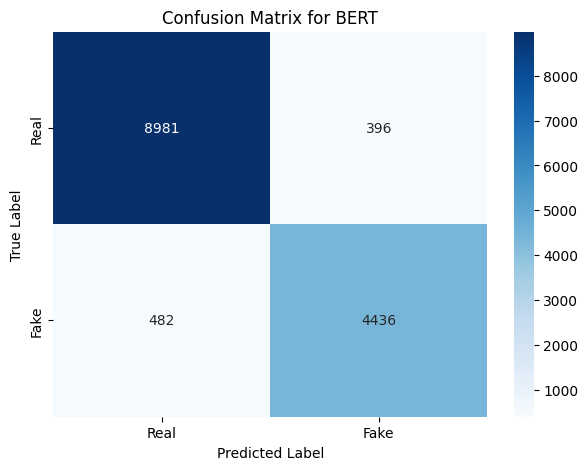

In [33]:
# Plot confusion matrix
# Compute the confusion matrix using y_test_enc and y_test_pred
cm_bert = confusion_matrix(y_test_enc, y_test_pred)
# Set the size of the plot
plt.figure(figsize=(7, 5))
# Plot the heatmap using seaborn and show annotations for each cell, set the color scheme and labels for the x and y axes
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
# Add the label for the y-axis
plt.ylabel('True Label')
# Add the label for the x-axis
plt.xlabel('Predicted Label')
# Add the title for the plot
plt.title('Confusion Matrix for BERT')
# Display the plot
plt.show()


## DistilBERT

In [24]:
# Create a DistilBertTokenizer object from the pre-trained 'distilbert-base-uncased' model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to encode the data using DistilBert tokenizer
def distilbert_encode(data, max_len):
    # Initialize empty lists for input_ids and attention_masks
    input_ids = []
    attention_masks = []

    # Loop through each text in the data
    for text in data:
        # Use the tokenizer to encode the text, truncate it if it is longer than max_len, pad it if it is shorter than max_len, and return the input ids and attention mask
        tokens = tokenizer.encode_plus(text, max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='tf')
        # Append the input ids and attention mask to the respective lists
        input_ids.append(tokens['input_ids'][0])
        attention_masks.append(tokens['attention_mask'][0])

    # Convert the input_ids and attention_masks lists to numpy arrays and return them
    return np.array(input_ids), np.array(attention_masks)
# Set the max length for the input sequences to 128
max_len = 128
# Encode the training and testing data using the distilbert_encode function
X_train_distilbert = distilbert_encode(X_train, max_len)
X_test_distilbert = distilbert_encode(X_test, max_len)

In [25]:
# Define a function to create a DistilBERT model
def create_distilbert_model():
    # Define the input layers for the model
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name="attention_masks")
    # Load the pre-trained DistilBERT model
    distilbert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    # Get the sequence output from the DistilBERT model
    sequence_output = distilbert_model([input_ids, attention_masks])[0]
    # Add a dense layer with sigmoid activation for binary classification
    output = Dense(1, activation='sigmoid')(sequence_output)
    # Define the model with inputs and outputs
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    return model
# Create a DistilBERT model
distilbert_model = create_distilbert_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [26]:
# Define the Adam optimizer with a learning rate of 2e-5
optimizer = Adam(learning_rate=2e-5)

# Compile the DistilBERT model with binary crossentropy loss and accuracy as metrics
distilbert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the DistilBERT model on the training set for 3 epochs with a batch size of 16 and 10% validation split
history = distilbert_model.fit(X_train_distilbert, y_train_enc, epochs=3, batch_size=16, validation_split=0.1)

Epoch 1/3
3217/3217 [==============================] - 165s 43ms/step - loss: 0.2383 - accuracy: 0.9017 - val_loss: 0.1852 - val_accuracy: 0.9292
Epoch 2/3
3217/3217 [==============================] - 117s 36ms/step - loss: 0.1281 - accuracy: 0.9511 - val_loss: 0.1682 - val_accuracy: 0.9397
Epoch 3/3
3217/3217 [==============================] - 115s 36ms/step - loss: 0.0648 - accuracy: 0.9775 - val_loss: 0.1956 - val_accuracy: 0.9377


In [27]:
# Predicting labels using DistilBERT model
y_pred_distilbert = distilbert_model.predict(X_test_distilbert)
# Converting probabilities to binary labels based on a threshold of 0.5
y_pred_distilbert = np.where(y_pred_distilbert > 0.5, 1, 0)

# Printing classification report for DistilBERT model
print("DistilBERT classification report:\n", classification_report(y_test_enc, y_pred_distilbert))

# Calculating train accuracy by predicting labels for the training set and comparing with actual labels
y_train_preddb = distilbert_model.predict(X_train_distilbert)
y_train_preddb = np.where(y_train_preddb > 0.5, 1, 0)
train_accuracydb = accuracy_score(y_train_enc, y_train_preddb)

# Calculating test accuracy by predicting labels for the test set and comparing with actual labels
y_test_preddb = distilbert_model.predict(X_test_distilbert)
y_test_preddb = np.where(y_test_preddb > 0.5, 1, 0)
test_accuracydb = accuracy_score(y_test_enc, y_test_preddb)

# Printing train and test accuracies
print("Train Accuracy:", train_accuracydb)
print("Test Accuracy:", test_accuracydb)

447/447 [==============================] - 11s 20ms/step
DistilBERT classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      9377
           1       0.92      0.90      0.91      4918

    accuracy                           0.94     14295
   macro avg       0.93      0.93      0.93     14295
weighted avg       0.94      0.94      0.94     14295

447/447 [==============================] - 9s 20ms/step
Train Accuracy: 0.9894017034225853
Test Accuracy: 0.9371108779293459


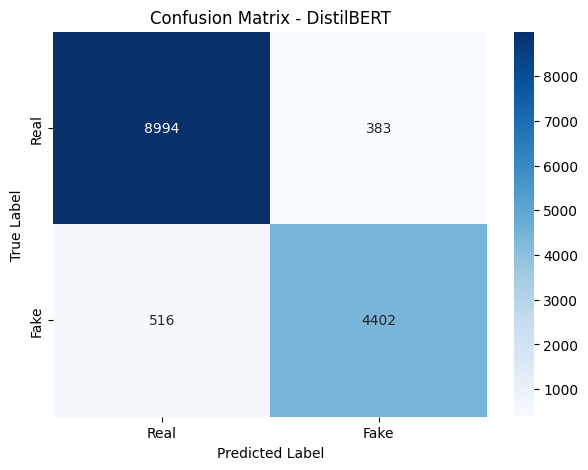

In [28]:
# Plot confusion matrix
# Compute the confusion matrix using y_test_enc and y_test_preddb
cm_db = confusion_matrix(y_test_enc, y_test_preddb)
# Set the size of the plot
plt.figure(figsize=(7, 5))
# Plot the heatmap using seaborn and show annotations for each cell, set the color scheme and labels for the x and y axes
sns.heatmap(cm_db, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
# Add the label for the y-axis
plt.ylabel('True Label')
# Add the label for the x-axis
plt.xlabel('Predicted Label')
# Add the title for the plot
plt.title('Confusion Matrix - DistilBERT')
# Display the plot
plt.show()

## AlBERT

In [39]:
# Load the pre-trained tokenizer for the ALBERT model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Define a function to encode the text data using the ALBERT tokenizer
def albert_encode(data, max_len):
    # Create empty lists to store the input ids and attention masks for the encoded data
    input_ids = []
    attention_masks = []

    # Loop through the input data
    for text in data:
        # Use the ALBERT tokenizer to encode each text sample
        tokens = tokenizer.encode_plus(text, max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='tf')
        # Extract the input ids and attention masks from the encoded tokens and append them to their respective lists
        input_ids.append(tokens['input_ids'][0])
        attention_masks.append(tokens['attention_mask'][0])

    # Convert the input ids and attention masks lists to numpy arrays and return them
    return np.array(input_ids), np.array(attention_masks)

# Define the maximum length of the encoded text
max_len = 128
# Encode the training and test data using the ALBERT tokenizer
X_train_albert = albert_encode(X_train, max_len)
X_test_albert = albert_encode(X_test, max_len)

In [40]:
#Define a function named create_albert_model that returns a Keras model
def create_albert_model():
    # Define two input layers for the input ids and attention masks, with shape max_len and data type int32
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name="attention_masks")
    # Load a pre-trained ALBERT model from Hugging Face transformers library, for sequence classification task
    albert_model = TFAlbertForSequenceClassification.from_pretrained("albert-base-v2")
    # Pass input_ids and attention_masks to the loaded ALBERT model and extract the sequence output tensor
    sequence_output = albert_model([input_ids, attention_masks])[0]
    # Add a dense layer with a single output unit and sigmoid activation function to the output of the ALBERT model
    output = Dense(1, activation='sigmoid')(sequence_output)

    # Create a Keras model with the input and output tensors
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    # Return the Keras model
    return model
    
# Call the create_albert_model function and assign the returned Keras model to the variable albert_model
albert_model = create_albert_model()

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the Adam optimizer with a learning rate of 2e-5
optimizer = Adam(learning_rate=2e-5)

# Compile the AlBERT model with binary crossentropy loss and accuracy as metrics
albert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the AlBERT model on the training set for 3 epochs with a batch size of 16 and 10% validation split
history = albert_model.fit(X_train_albert, y_train_enc, epochs=3, batch_size=16, validation_split=0.1)

Epoch 1/3
3217/3217 [==============================] - 1356s 410ms/step - loss: 0.2969 - accuracy: 0.8717 - val_loss: 0.2321 - val_accuracy: 0.9050
Epoch 2/3
3217/3217 [==============================] - 1311s 407ms/step - loss: 0.2286 - accuracy: 0.9084 - val_loss: 0.2430 - val_accuracy: 0.8984
Epoch 3/3
3217/3217 [==============================] - 1308s 407ms/step - loss: 0.1749 - accuracy: 0.9332 - val_loss: 0.1938 - val_accuracy: 0.9286


In [ ]:
# Predicting labels using AlBERT model
y_pred_albert = albert_model.predict(X_test_albert)
# Converting probabilities to binary labels based on a threshold of 0.5
y_pred_albert = np.where(y_pred_albert > 0.5, 1, 0)

# Printing classification report for AlBERT model
print("AlBERT classification report:\n", classification_report(y_test_enc, y_pred_albert))

# Calculating train accuracy by predicting labels for the training set and comparing with actual labels
y_train_predab = albert_model.predict(X_train_albert)
y_train_predab = np.where(y_train_predab > 0.5, 1, 0)
train_accuracyab = accuracy_score(y_train_enc, y_train_predab)

# Calculating test accuracy by predicting labels for the test set and comparing with actual labels
y_test_predab = albert_model.predict(X_test_albert)
y_test_predab = np.where(y_test_predab > 0.5, 1, 0)
test_accuracyab = accuracy_score(y_test_enc, y_test_predab)

# Printing train and test accuracies
print("Train Accuracy:", train_accuracyab)
print("Test Accuracy:", test_accuracyab)

447/447 [==============================] - 132s 287ms/step
AlBERT classification report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      9377
           1       0.89      0.90      0.90      4918

    accuracy                           0.93     14295
   macro avg       0.92      0.92      0.92     14295
weighted avg       0.93      0.93      0.93     14295



447/447 [==============================] - 129s 288ms/step
Train Accuracy: 0.9570996344811906
Test Accuracy: 0.9274571528506471


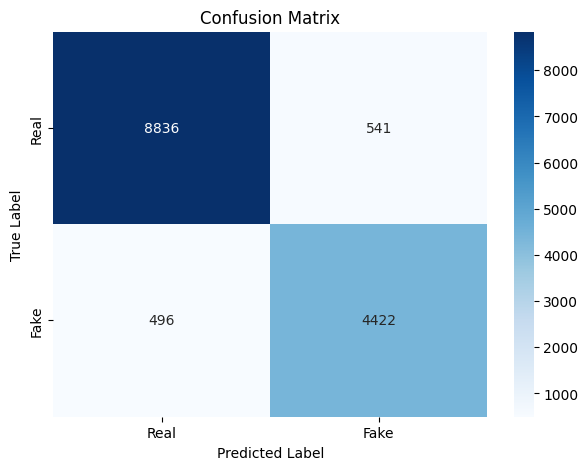

In [ ]:

# Plot confusion matrix
# Create a confusion matrix by comparing the encoded true labels of the test set and the predicted labels of the test set using AlBERT model
cm_ab = confusion_matrix(y_test_enc, y_test_predab)

# Create a figure with size 7x5
plt.figure(figsize=(7, 5))

# Draw a heatmap for the confusion matrix using seaborn, with annotations of the values in the cells and a blue color map.
# Set the tick labels for the x and y axis as 'Real' and 'Fake'
sns.heatmap(cm_ab, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])

# Set the y and x axis labels and the title of the plot
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - AlBERT')

# Display the plot
plt.show()

## RoBERTa

In [34]:
# Define a function to encode the input data using the RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Initialize empty lists for input_ids and attention_masks
def roberta_encode(data, max_len):
    input_ids = []
    attention_masks = []

    # Loop over each text in the input data
    for text in data:
        # Use the tokenizer to encode the text with specified maximum length, padding, and special tokens
        tokens = tokenizer.encode_plus(text, max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='tf')
        # Append the input_ids and attention_masks to their respective lists
        input_ids.append(tokens['input_ids'][0])
        attention_masks.append(tokens['attention_mask'][0])

    # Convert the input_ids and attention_masks lists to numpy arrays and return them
    return np.array(input_ids), np.array(attention_masks)

# Set the maximum length for encoding
max_len = 128
# Encode the training and testing data using the roberta_encode function
X_train_roberta = roberta_encode(X_train, max_len)
X_test_roberta = roberta_encode(X_test, max_len)


In [35]:
#Define a function named create_roberta_model that returns a Keras model
def create_roberta_model():
    # Define two input layers for the input ids and attention masks, with shape max_len and data type int32
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name="attention_masks")
    # Load a pre-trained RoBERTa model from Hugging Face transformers library, for sequence classification task
    roberta_model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
    # Pass input_ids and attention_masks to the loaded RoBERTa model and extract the sequence output tensor
    sequence_output = roberta_model([input_ids, attention_masks])[0]
    # Add a dense layer with a single output unit and sigmoid activation function to the output of the RoBERTa model
    output = Dense(1, activation='sigmoid')(sequence_output)

    # Create a Keras model with the input and output tensors
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    # Return the Keras model
    return model

# Call the create_albert_model function and assign the returned Keras model to the variable roberta_model
roberta_model = create_roberta_model()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Define the Adam optimizer with a learning rate of 2e-5
optimizer = Adam(learning_rate=2e-5)
# Compile the RoBERTa model with binary crossentropy loss and accuracy as metrics
roberta_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the RoBERTa model on the training set for 3 epochs with a batch size of 16 and 10% validation split
history = roberta_model.fit(X_train_roberta, y_train_enc, epochs=3, batch_size=16, validation_split=0.1)

Epoch 1/3
3217/3217 [==============================] - 305s 81ms/step - loss: 0.2716 - accuracy: 0.8868 - val_loss: 0.2041 - val_accuracy: 0.9190
Epoch 2/3
3217/3217 [==============================] - 223s 69ms/step - loss: 0.1770 - accuracy: 0.9324 - val_loss: 0.1894 - val_accuracy: 0.9332
Epoch 3/3
3217/3217 [==============================] - 221s 69ms/step - loss: 0.1284 - accuracy: 0.9523 - val_loss: 0.1770 - val_accuracy: 0.9344


In [37]:
# Predicting labels using RoBERTa model
y_pred_roberta = roberta_model.predict(X_test_roberta)
# Converting probabilities to binary labels based on a threshold of 0.5
y_pred_roberta = np.where(y_pred_roberta > 0.5, 1, 0)

# Printing classification report for RoBERTa model
print("RoBERTa classification report:\n", classification_report(y_test_enc, y_pred_roberta))

# Calculating train accuracy by predicting labels for the training set and comparing with actual labels
y_train_predrb = roberta_model.predict(X_train_roberta)
y_train_predrb = np.where(y_train_predrb > 0.5, 1, 0)
train_accuracyrb = accuracy_score(y_train_enc, y_train_predrb)

# Calculating test accuracy by predicting labels for the test set and comparing with actual labels
y_test_predrb = roberta_model.predict(X_test_roberta)
y_test_predrb = np.where(y_test_predrb > 0.5, 1, 0)
test_accuracyrb = accuracy_score(y_test_enc, y_test_predrb)

# Printing train and test accuracies
print("Train Accuracy:", train_accuracyrb)
print("Test Accuracy:", test_accuracyrb)

447/447 [==============================] - 21s 39ms/step
RoBERTa classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      9377
           1       0.91      0.91      0.91      4918

    accuracy                           0.94     14295
   macro avg       0.93      0.93      0.93     14295
weighted avg       0.94      0.94      0.94     14295

447/447 [==============================] - 18s 40ms/step
Train Accuracy: 0.9775267143531716
Test Accuracy: 0.9385099685204616


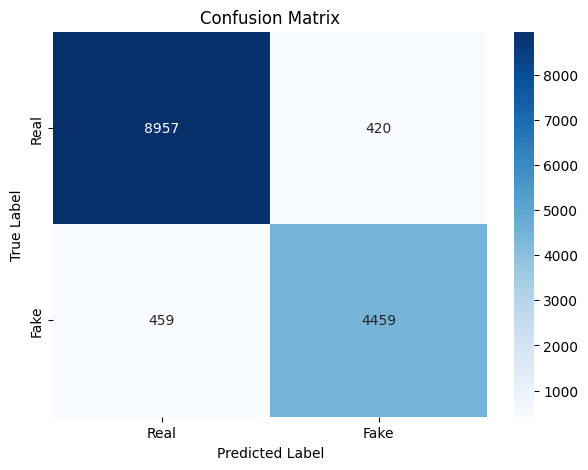

In [38]:
# Plot confusion matrix
# Create a confusion matrix by comparing the encoded true labels of the test set and the predicted labels of the test set using RoBERTa model
cm_rb = confusion_matrix(y_test_enc, y_test_predrb)
# Create a figure with size 7x5
plt.figure(figsize=(7, 5))

# Draw a heatmap for the confusion matrix using seaborn, with annotations of the values in the cells and a blue color map.
# Set the tick labels for the x and y axis as 'Real' and 'Fake'
sns.heatmap(cm_rb, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])

# Set the y and x axis labels and the title of the plot
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## XLNet

In [41]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

def xlnet_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for text in data:
        tokens = tokenizer.encode_plus(text, max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='tf')
        input_ids.append(tokens['input_ids'][0])
        attention_masks.append(tokens['attention_mask'][0])

    return np.array(input_ids), np.array(attention_masks)

max_len = 128
X_train_xlnet = xlnet_encode(X_train, max_len)
X_test_xlnet = xlnet_encode(X_test, max_len)

In [42]:
def create_xlnet_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name="attention_masks")
    xlnet_model = TFXLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
    sequence_output = xlnet_model([input_ids, attention_masks])[0]
    output = Dense(1, activation='sigmoid')(sequence_output)

    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    return model

xlnet_model = create_xlnet_model()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequ

In [43]:
# Define the Adam optimizer with a learning rate of 2e-5
optimizer = Adam(learning_rate=2e-5)

# Compile the XLNet model with binary crossentropy loss and accuracy as metrics
xlnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the XLNet model on the training set for 3 epochs with a batch size of 16 and 10% validation split
history = xlnet_model.fit(X_train_xlnet, y_train_enc, epochs=3, batch_size=16, validation_split=0.1)

Epoch 1/3


3217/3217 [==============================] - 304s 81ms/step - loss: 0.2894 - accuracy: 0.8756 - val_loss: 0.2069 - val_accuracy: 0.9173
Epoch 2/3
3217/3217 [==============================] - 241s 75ms/step - loss: 0.1882 - accuracy: 0.9268 - val_loss: 0.2002 - val_accuracy: 0.9288
Epoch 3/3
3217/3217 [==============================] - 240s 75ms/step - loss: 0.1358 - accuracy: 0.9500 - val_loss: 0.2252 - val_accuracy: 0.9211


In [45]:
# Predicting labels using AlBERT model
y_pred_xlnet = xlnet_model.predict(X_test_xlnet)
# Converting probabilities to binary labels based on a threshold of 0.5
y_pred_xlnet = np.where(y_pred_xlnet > 0.5, 1, 0)

# Printing classification report for AlBERT model
print("XLNet classification report:\n", classification_report(y_test_enc, y_pred_xlnet))

# Calculating train accuracy by predicting labels for the training set and comparing with actual labels
y_train_predxlnet = roberta_model.predict(X_train_xlnet)
y_train_predxlnet = np.where(y_train_predxlnet > 0.5, 1, 0)
train_accuracyxlnet = accuracy_score(y_train_enc, y_train_predxlnet)

# Calculating test accuracy by predicting labels for the test set and comparing with actual labels
y_test_predxlnet = xlnet_model.predict(X_test_xlnet)
y_test_predxlnet = np.where(y_test_predxlnet > 0.5, 1, 0)
test_accuracyxlnet = accuracy_score(y_test_enc, y_test_predxlnet)

# Printing train and test accuracies
print("Train Accuracy:", train_accuracyxlnet)
print("Test Accuracy:", test_accuracyxlnet)

447/447 [==============================] - 18s 40ms/step
XLNet classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      9377
           1       0.86      0.93      0.90      4918

    accuracy                           0.93     14295
   macro avg       0.91      0.93      0.92     14295
weighted avg       0.93      0.93      0.93     14295

447/447 [==============================] - 18s 40ms/step
Train Accuracy: 0.6559925846901835
Test Accuracy: 0.9255683805526408


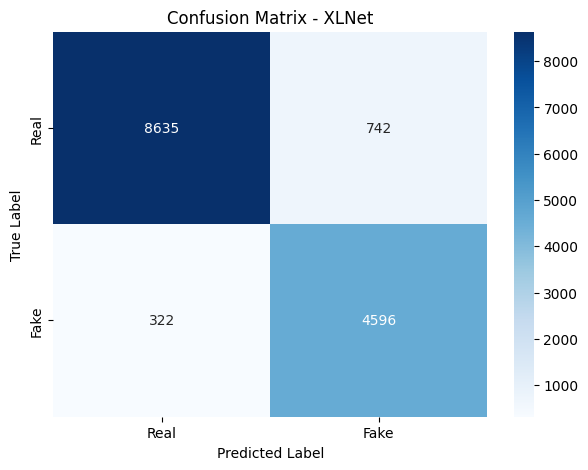

In [46]:
# Plot confusion matrix
# Create a confusion matrix by comparing the encoded true labels of the test set and the predicted labels of the test set using XLNet model
cm_xlnet = confusion_matrix(y_test_enc, y_test_predxlnet)
# Create a figure with size 7x5
plt.figure(figsize=(7, 5))
# Draw a heatmap for the confusion matrix using seaborn, with annotations of the values in the cells and a blue color map.
# Set the tick labels for the x and y axis as 'Real' and 'Fake'
sns.heatmap(cm_xlnet, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])

# Set the y and x axis labels and the title of the plot
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - XLNet')

# Display the plot
plt.show()